In [ ]:

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torchvision import datasets, transforms

from hyperspherical_vae.distributions import VonMisesFisher
from hyperspherical_vae.distributions import HypersphericalUniform


train_loader = torch.utils.data.DataLoader(datasets.MNIST('./data', train=True, download=True,
    transform=transforms.ToTensor()), batch_size=512, shuffle=True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(datasets.MNIST('./data', train=False, download=True,
    transform=transforms.ToTensor()), batch_size=512, pin_memory=True)


In [2]:

class ModelVAE(torch.nn.Module):
    
    def __init__(self, h_dim, z_dim, activation=F.relu, distribution='vmf'):
        """
        ModelVAE initializer
        :param h_dim: dimension of the hidden layers
        :param z_dim: dimension of the latent representation
        :param activation: callable activation function
        :param distribution: string either `normal` or `vmf`, indicates which distribution to use
        """
        super(ModelVAE, self).__init__()
        
        self.z_dim, self.activation, self.distribution = z_dim, activation, distribution
        
        # 2 hidden layers encoder
        self.fc_e0 = nn.Linear(784, h_dim * 2)
        self.fc_e1 = nn.Linear(h_dim * 2, h_dim)

        if self.distribution == 'normal':
            # compute mean and std of the normal distribution
            self.fc_mean = nn.Linear(h_dim, z_dim)
            self.fc_var =  nn.Linear(h_dim, z_dim)
        elif self.distribution == 'vmf':
            # compute mean and concentration of the von Mises-Fisher
            self.fc_mean = nn.Linear(h_dim, z_dim)
            self.fc_var = nn.Linear(h_dim, 1)
        else:
            raise NotImplemented
            
        # 2 hidden layers decoder
        self.fc_d0 = nn.Linear(z_dim, h_dim)
        self.fc_d1 = nn.Linear(h_dim, h_dim * 2)
        self.fc_logits = nn.Linear(h_dim * 2, 784)

    def encode(self, x):
        # 2 hidden layers encoder
        x = self.activation(self.fc_e0(x))
        x = self.activation(self.fc_e1(x))
        
        if self.distribution == 'normal':
            # compute mean and std of the normal distribution
            z_mean = self.fc_mean(x)
            z_var = F.softplus(self.fc_var(x))
        elif self.distribution == 'vmf':
            # compute mean and concentration of the von Mises-Fisher
            z_mean = self.fc_mean(x)
            z_mean = z_mean / z_mean.norm(dim=-1, keepdim=True)
            # the `+ 1` prevent collapsing behaviors
            z_var = F.softplus(self.fc_var(x)) + 1
        else:
            raise NotImplemented
        
        return z_mean, z_var
        
    def decode(self, z):
        
        x = self.activation(self.fc_d0(z))
        x = self.activation(self.fc_d1(x))
        x = self.fc_logits(x)
        
        return x
        
    def reparameterize(self, z_mean, z_var):
        if self.distribution == 'normal':
            q_z = torch.distributions.normal.Normal(z_mean, z_var)
            p_z = torch.distributions.normal.Normal(torch.zeros_like(z_mean), torch.ones_like(z_var))
        elif self.distribution == 'vmf':
            q_z = VonMisesFisher(z_mean, z_var)
            p_z = HypersphericalUniform(self.z_dim - 1, device=z_mean.device)
        else:
            raise NotImplemented

        return q_z, p_z
        
    def forward(self, x): 
        z_mean, z_var = self.encode(x)
        q_z, p_z = self.reparameterize(z_mean, z_var)
        z = q_z.rsample()
        x_ = self.decode(z)
        
        return (z_mean, z_var), (q_z, p_z), z, x_
    
    
def log_likelihood(model, x, n=10):
    """
    :param model: model object
    :param optimizer: optimizer object
    :param n: number of MC samples
    :return: MC estimate of log-likelihood
    """

    z_mean, z_var = model.encode(x.reshape(-1, 784))
    q_z, p_z = model.reparameterize(z_mean, z_var)
    z = q_z.rsample(torch.Size([n]))
    x_mb_ = model.decode(z)

    log_p_z = p_z.log_prob(z)

    if model.distribution == 'normal':
        log_p_z = log_p_z.sum(-1)

    log_p_x_z = -nn.BCEWithLogitsLoss(reduction='none')(x_mb_, x.reshape(-1, 784).repeat((n, 1, 1))).sum(-1)

    log_q_z_x = q_z.log_prob(z)

    if model.distribution == 'normal':
        log_q_z_x = log_q_z_x.sum(-1)

    return ((log_p_x_z + log_p_z - log_q_z_x).t().logsumexp(-1) - np.log(n)).mean()

# ----------------------------------------------------------------------
# Extra imports
# ----------------------------------------------------------------------
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from torchvision.utils import make_grid
from tqdm.auto import tqdm

# ----------------------------------------------------------------------
# Utilities
# ----------------------------------------------------------------------

def train_epoch(model, loader, optimiser):
    model.train()
    epoch_loss = 0
    for x_mb, _ in loader:
        x_mb = x_mb.to(device, non_blocking=True)
        x_mb = (x_mb > torch.rand_like(x_mb, device=device)).float()     # dynamic binarisation
        optimiser.zero_grad()
        _, (q_z, p_z), _, x_mb_ = model(x_mb.view(-1, 784))
        recon = nn.functional.binary_cross_entropy_with_logits(
            x_mb_, x_mb.view(-1, 784), reduction="none"
        ).sum(-1).mean()

        if model.distribution == "normal":
            kl = torch.distributions.kl.kl_divergence(q_z, p_z).sum(-1).mean()
        else:  # vmf
            kl = torch.distributions.kl.kl_divergence(q_z, p_z).mean()

        loss = recon + kl
        loss.backward()
        optimiser.step()
        epoch_loss += loss.item() * x_mb.size(0)
    return epoch_loss / len(loader.dataset)

@torch.no_grad()
def eval_epoch(model, loader):
    model.eval()
    recon_l, kl_l = [], []
    for x_mb, _ in loader:
        x_mb = (x_mb > torch.rand_like(x_mb)).float().to(device)
        _, (q_z, p_z), _, x_mb_ = model(x_mb.view(-1, 784))
        recon_l.append(
            nn.functional.binary_cross_entropy_with_logits(
                x_mb_, x_mb.view(-1, 784), reduction="none"
            ).sum(-1)
        )
        if model.distribution == "normal":
            kl_l.append(torch.distributions.kl.kl_divergence(q_z, p_z).sum(-1))
        else:
            kl_l.append(torch.distributions.kl.kl_divergence(q_z, p_z))
    recon = torch.cat(recon_l).mean().item()
    kl = torch.cat(kl_l).mean().item()
    return recon, kl, -(recon + kl)


def run_training(model, optimiser, epochs, name=""):
    model.to(device)
    for ep in range(1, epochs + 1):
        tl = train_epoch(model, train_loader, optimiser)
        recon, kl, elbo = eval_epoch(model, test_loader)
        print(f"{name} | epoch {ep:02d} | train loss {tl:.3f} | "
              f"recon {recon:.3f} | KL {kl:.3f} | ELBO {elbo:.3f}")

# ----------------------------------------------------------------------
# Visualisation helpers
# ----------------------------------------------------------------------
@torch.no_grad()
def latent_plot(model, loader, n_batches=100):
    zs, ys = [], []
    for i, (x_mb, y_mb) in enumerate(loader):
        if i >= n_batches: break
        z_mean, _ = model.encode(x_mb.view(-1, 784).to(device))
        zs.append(z_mean.cpu())
        ys.append(y_mb)
    z = torch.cat(zs)
    y = torch.cat(ys)
    z_2d = PCA(n_components=2).fit_transform(z)
    plt.figure(figsize=(6,5))
    scatter = plt.scatter(z_2d[:,0], z_2d[:,1], c=y, cmap='tab10', s=8, alpha=.7)
    plt.title(f"Latent space ({model.distribution})")
    plt.colorbar(scatter, ticks=range(10))
    plt.tight_layout()
    plt.show()


@torch.no_grad()
def reconstructions(model, loader, n=8):
    model.eval()
    x_mb, _ = next(iter(loader))
    x_mb = x_mb.to(device)[:n]
    _, _, _, x_rec_logits = model(x_mb.view(-1, 784))
    x_rec = torch.sigmoid(x_rec_logits).view(-1,1,28,28)
    grid = make_grid(torch.cat([x_mb.cpu(), x_rec.cpu()]), nrow=n, pad_value=1)
    plt.figure(figsize=(n,2))
    plt.imshow(grid.permute(1,2,0))
    plt.axis('off')
    plt.title(f"Top: originals | Bottom: reconstructions ({model.distribution})")
    plt.show()


@torch.no_grad()
def samples(model, n=64):
    model.eval()
    if model.distribution == "normal":
        z = torch.randn(n, model.z_dim, device=device)
    else:  # uniform on the hypersphere
        p_z = HypersphericalUniform(model.z_dim - 1)
        z = p_z.sample(torch.Size([n])).to(device)
    x_logits = model.decode(z)
    x = torch.sigmoid(x_logits).view(-1,1,28,28)
    grid = make_grid(x.cpu(), nrow=int(n**0.5), pad_value=1)
    plt.figure(figsize=(6,6))
    plt.imshow(grid.permute(1,2,0))
    plt.axis('off')
    plt.title(f"Generated samples ({model.distribution})")
    plt.show()



/Users/joyqiu/anaconda3/envs/svae/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



##### Normal VAE Training #####
Normal | epoch 01 | train loss 209.479 | recon 164.120 | KL 6.078 | ELBO -170.198
Normal | epoch 02 | train loss 154.447 | recon 133.679 | KL 9.666 | ELBO -143.345
Normal | epoch 03 | train loss 140.222 | recon 126.205 | KL 10.585 | ELBO -136.790
Normal | epoch 04 | train loss 134.975 | recon 122.258 | KL 10.520 | ELBO -132.778
Normal | epoch 05 | train loss 131.851 | recon 118.987 | KL 10.728 | ELBO -129.715
Normal | epoch 06 | train loss 129.702 | recon 117.792 | KL 10.694 | ELBO -128.486
Normal | epoch 07 | train loss 128.137 | recon 116.044 | KL 11.243 | ELBO -127.287
Normal | epoch 08 | train loss 126.788 | recon 114.958 | KL 10.900 | ELBO -125.858
Normal | epoch 09 | train loss 125.806 | recon 114.066 | KL 10.985 | ELBO -125.051
Normal | epoch 10 | train loss 124.889 | recon 113.172 | KL 11.276 | ELBO -124.448
Normal | epoch 11 | train loss 124.106 | recon 112.388 | KL 11.107 | ELBO -123.495
Normal | epoch 12 | train loss 123.403 | recon 111.664 |

/Users/joyqiu/anaconda3/envs/svae/lib/python3.12/site-packages/torch/distributions/distribution.py:62: UserWarning: <class 'hyperspherical_vae.distributions.hyperspherical_uniform.HypersphericalUniform'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


vMF | epoch 01 | train loss 220.221 | recon 176.195 | KL 4.710 | ELBO -180.905
vMF | epoch 02 | train loss 162.976 | recon 142.593 | KL 8.168 | ELBO -150.761
vMF | epoch 03 | train loss 144.850 | recon 130.362 | KL 9.418 | ELBO -139.780
vMF | epoch 04 | train loss 137.478 | recon 124.662 | KL 9.977 | ELBO -134.639
vMF | epoch 05 | train loss 133.680 | recon 121.531 | KL 10.311 | ELBO -131.842
vMF | epoch 06 | train loss 131.334 | recon 119.334 | KL 10.549 | ELBO -129.883
vMF | epoch 07 | train loss 129.438 | recon 117.358 | KL 10.750 | ELBO -128.107
vMF | epoch 08 | train loss 128.138 | recon 116.385 | KL 10.894 | ELBO -127.279
vMF | epoch 09 | train loss 126.940 | recon 114.814 | KL 11.009 | ELBO -125.823
vMF | epoch 10 | train loss 125.943 | recon 114.231 | KL 11.126 | ELBO -125.356
vMF | epoch 11 | train loss 125.100 | recon 113.229 | KL 11.213 | ELBO -124.442
vMF | epoch 12 | train loss 124.357 | recon 112.490 | KL 11.313 | ELBO -123.802
vMF | epoch 13 | train loss 123.752 | recon 

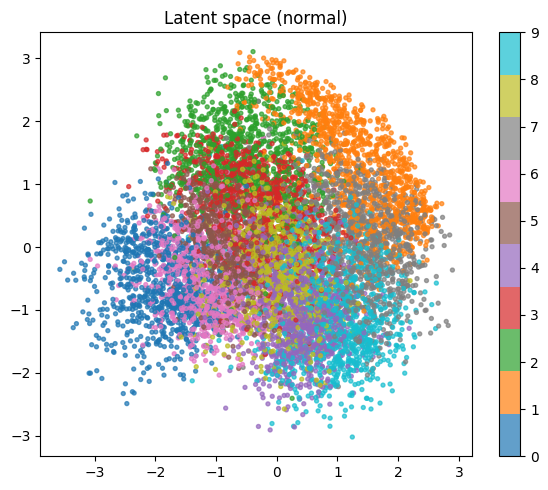

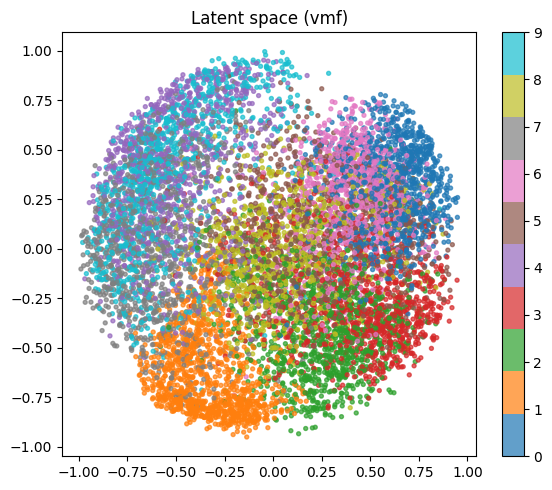


--- Reconstructions ---


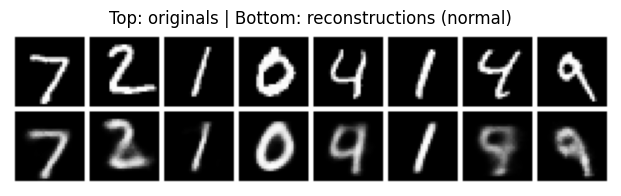

/Users/joyqiu/anaconda3/envs/svae/lib/python3.12/site-packages/torch/distributions/distribution.py:62: UserWarning: <class 'hyperspherical_vae.distributions.hyperspherical_uniform.HypersphericalUniform'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


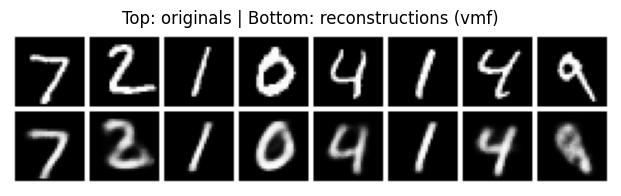


--- New samples ---


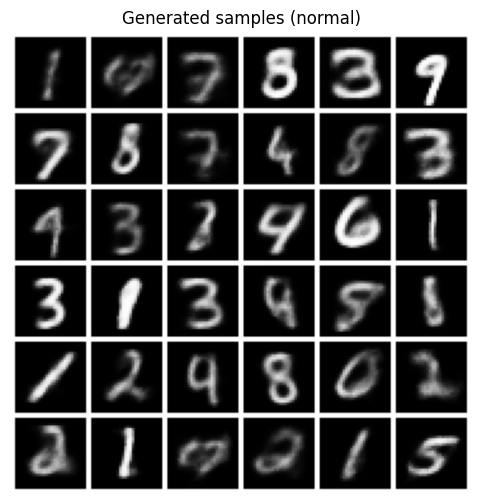

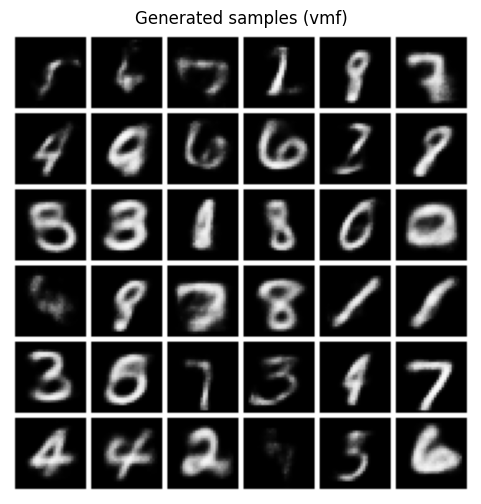

In [3]:

# ----------------------------------------------------------------------
# 1. FULL TRAINING
# ----------------------------------------------------------------------

H_DIM = 128
Z_DIM = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

modelN = ModelVAE(h_dim=H_DIM, z_dim=Z_DIM, distribution='normal').to(device)
optimizerN = optim.Adam(modelN.parameters(), lr=1e-3)

modelS = ModelVAE(h_dim=H_DIM, z_dim=Z_DIM + 1, distribution='vmf').to(device)
optimizerS = optim.Adam(modelS.parameters(), lr=1e-3)


EPOCHS = 20          # adjust to taste

print("\n##### Normal VAE Training #####")
run_training(modelN, optimizerN, EPOCHS, "Normal")

print("\n##### Hyper-spherical VAE Training #####")
run_training(modelS, optimizerS, EPOCHS, "vMF")

# ----------------------------------------------------------------------
# 2. VISUALISE
# ----------------------------------------------------------------------
print("\n--- Embedding spaces ---")
latent_plot(modelN, test_loader)
latent_plot(modelS, test_loader)

print("\n--- Reconstructions ---")
reconstructions(modelN, test_loader)
reconstructions(modelS, test_loader)

print("\n--- New samples ---")
samples(modelN, n=36)
samples(modelS, n=36)
